# Peru Regional Telemetry

This Jupyter Notebook serves as the primary "laboratory" for developing the data pipeline for the **Peru Regional Telemetry** Streamlit application.

The purpose of this notebook is to document the full `end-to-end` process of `data analysis`: from initial configuration and raw API calls to final, chart-ready data prototypes. The validated logic from this notebook will then be refactored into the final Streamlit application.

## Mission Workflow:

This notebook is structured in the following phases:

1.  **Phase 1: Configuration & Data Fetching:** Define API constants, set up location data, and perform a one-time API call to save the raw JSON data locally.
2.  **Phase 2: Data Exploration:** Load the local JSON file and analyze its nested structure (`metadata`, `units`, `data_1h`) to identify the target data.
3.  **Phase 3: Data Transformation (Pandas):** Convert the raw data into a clean Pandas DataFrame, handle data types (especially `datetime`), and create new "smoothed" columns for trend analysis.
4.  **Phase 4: Visualization Setup (Defining Function)** Define a function for our plotting charts & visualizations.
5.  **Phase 5: 7-Day Overview Visualization (Matplotlib):** Prototype the main 7-day forecast charts (Temperature & Precipitation) using Matplotlib.
6.  **Phase 6: 1-Day Detail Visualization (Matplotlib):** Prototype the detailed 24-hour charts for a selected day, including X-axis formatting.
7.  **Phase 7: Conclusion:** Confirm the data pipeline is validated and ready to be transferred to the Streamlit application.

## Phase 1: Configuration & Data Fetching

This initial phase covers all setup steps required to make a single, successful API call and save the raw data locally for analysis.

### 1.1. Define Locations

First, we import and inspect the list of pre-defined locations from the `data.py` module. This provides an overview of the provinces and specific cities that will serve as the selectable options in the final Streamlit application.

In [1]:
from data import data

province_count = len(data)
print(f"Number of provinces: {province_count}")

location_count = 0
for province in data:
    location_in_province = len(province["cities"])
    # in case we have more than 1 location within a province
    # print(f"Number of locations in {province["name"]}: {cities_in_province}") 
    location_count += location_in_province
print(f"Number of locations: {location_count}")

for province in data:
    print(f"""
Province:        {province["name"]} 
Location (City): {province["cities"][0]["name"]} 
Coordinates:     latitude: {province["cities"][0]["location"]["lat"]} longitude: {province["cities"][0]["location"]["lon"]}""")

Number of provinces: 7
Number of locations: 7

Province:        Cajamarca 
Location (City): Cajamarca 
Coordinates:     latitude: -7.16 longitude: -78.52

Province:        Apurimac 
Location (City): Abancay 
Coordinates:     latitude: -13.63 longitude: -72.88

Province:        Madre de Dios 
Location (City): Puerto Maldonado 
Coordinates:     latitude: -12.6 longitude: -69.18

Province:        La Libertad 
Location (City): Trujillo 
Coordinates:     latitude: -8.12 longitude: -79.03

Province:        Arequipa 
Location (City): Arequipa 
Coordinates:     latitude: -16.4 longitude: -71.54

Province:        Ancash 
Location (City): Huaraz 
Coordinates:     latitude: -9.53 longitude: -77.53

Province:        Ica 
Location (City): Ica 
Coordinates:     latitude: -14.07 longitude: -75.73


### 1.2. Set API Constants

Next, we set up all required constants for the API call and import necessary libraries (`requests`, `dotenv`). This includes loading the secret `API_KEY` from the `.env` file, defining the API base URLs, selecting a single test location (Huaraz), and setting the output filename for the raw data.

In [ ]:
import os
import requests
import json
from dotenv import load_dotenv

# --- Configuration ---

# Load environment variables (API key) from a .env file
load_dotenv()
#API_KEY = os.getenv("METEOBLUE_API_KEY")

# The base URL for location - the API package
LOCATION_URL = "https://www.meteoblue.com/en/server/search/query3"

# The base URL for meteodata - the API package
METEODATA_URL = "https://my.meteoblue.com/packages/basic-1h"

# Location / City (Huaraz) - for testing
CITY_QUERY = data[5]['cities'][0]['name']
LAT = data[5]['cities'][0]['location']['lat']
LON = data[5]['cities'][0]['location']['lon']

# Output filename for the raw data
OUTPUT_FILE = "meteo_data_raw_huaraz.json"

### 1.3. Define API Call Function

This function (`fetch_weather_data`) performs the actual API call using the constants defined above. It includes error handling and saves the raw JSON response to the specified `OUTPUT_FILE`.

In [3]:
# --- Main function ---

def fetch_weather_data():
    """
    Fetches weather data from the Meteoblue API and saves it to a file.
    """
    # 1. Check if the API key is available
    if not API_KEY:
        print("Error: API_KEY not found in .env file.")
        return

    # 2. Set up the request parameters:
    # get location coordinates, force units
    location_params = {
        'apikey': API_KEY,
        'query': CITY_QUERY,
        'format': 'json',
        'forecast_days': 7,
        'temperature': 'C',       
        'windspeed': 'ms-1',      
        'precipitationamount': 'mm' 
    }

    # get data for a location
    meteo_params = {
        'apikey': API_KEY,
        'lat': LAT,
        'lon': LON,
        'format': 'json'
    }

    print(f"Fetching data for '{CITY_QUERY.title()}' from Meteoblue API...")

    # 3. Make the API call to fetch meteo data
    try:
        response = requests.get(METEODATA_URL, params=meteo_params)
        response.raise_for_status() 

    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP Error occurred: {http_err}")
        print(f"Response content: {response.text}")
        return
    except requests.exceptions.RequestException as err:
        print(f"An error occurred: {err}")
        return

    # 4. Process the successful response
    try:
        data = response.json()
        print("Successfully fetched and decoded JSON data.")

        # 5. Save the raw data to a file for offline analysis
        with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=4, ensure_ascii=False)
        
        print(f"Raw data saved to '{OUTPUT_FILE}'.")
        print("It is possible now start analyzing data without API calls.")

    except requests.exceptions.JSONDecodeError:
        print("Error: Failed to decode JSON from the response.")
        print(f"Received text: {response.text[:200]}...") # Show snippet of response

### 1.4. Execute Data Fetch (One-Time Run)

We execute the function to download the data. This cell is only run once.

In [4]:
#if __name__ == "__main__":
    #fetch_weather_data()

## Phase 2: Data Exploration (Offline Analysis)

Now that the raw data is saved locally in `.json` file, we can begin the exploration phase. All work from this point forward will use this local file, saving API credits.

### 2.1. Inspect Top-Level Structure

By printing the `the top-level keys` of the dictionary, we get a "table of contents" for the entire API response. This tells us where to look for the main data versus the contextual information.

In [5]:
import json

with open("meteo_data_raw_huaraz.json", mode="r", encoding="utf-8") as f:
    raw_data = json.load(f)

# exploring JSON object structure
print(raw_data.keys()) # top level keys - 'metadata', 'units', 'data_1h'

# top-level keys
metadata = raw_data['metadata']
units = raw_data["units"]
data_1h = raw_data["data_1h"]

dict_keys(['metadata', 'units', 'data_1h'])


### 2.2. Isolate Data and Context

The keys confirm the three main sections: `metadata`, `units`, and the main timeseries data (`data_1h`). We'll assign these to separate variables for clarity.

The `metadata` and `units` dictionaries are valuable context that we can pass to the Streamlit app later (e.g., for chart titles, axis labels, and location info).

In [6]:
# exploring data

print(metadata) # location specific info (coordinates, date, time ..)
print(units) # units used for measurements
print(data_1h.keys()) # getting keys to target data

{'modelrun_updatetime_utc': '2025-11-05 03:05', 'name': '', 'height': 3059, 'timezone_abbrevation': 'GMT-05', 'latitude': -9.53, 'modelrun_utc': '2025-11-05 03:05', 'longitude': -77.53, 'utc_timeoffset': -5.0, 'generation_time_ms': 7.6600313}
{'precipitation': 'mm', 'windspeed': 'ms-1', 'precipitation_probability': 'percent', 'relativehumidity': 'percent', 'temperature': 'C', 'time': 'YYYY-MM-DD hh:mm', 'pressure': 'hPa', 'winddirection': 'degree'}
dict_keys(['time', 'snowfraction', 'windspeed', 'temperature', 'precipitation_probability', 'convective_precipitation', 'rainspot', 'pictocode', 'felttemperature', 'precipitation', 'isdaylight', 'uvindex', 'relativehumidity', 'sealevelpressure', 'winddirection'])


## Phase 3: Data Transformation (Pandas)

Now that we have isolated the `data_1h` object, our goal is to transform it from a Python dictionary of lists into a clean, usable Pandas DataFrame for analysis and plotting.

### 3.1. Inspect Timeseries Data

First, let's verify the contents of the `data_1h` dictionary. We'll check the length of the key lists (like `time`, `temperature`, etc.) to ensure they are all consistent. This confirms the data is "tabular" (all columns have the same number of rows) and ready to be loaded into a DataFrame.

In [7]:
print(f"""
Number of entries: {len(data_1h["time"])}
    timestamp (YYYY-mm-dd): {data_1h["time"]}""") # time period (1h)
print(f"""
Number of entries: {len(data_1h["temperature"])}
    temperature (°C): {data_1h["temperature"]}""") # temperature in degrees °C
print(f"""
Number of entries: {len(data_1h["felttemperature"])}
    'felt' temperature (°C): {data_1h["felttemperature"]}""") # "felt" temperature in degrees °C
print(f"""
Number of entries: {len(data_1h["precipitation"])}
    all precipitations (mm): {data_1h["precipitation"]}""") # all precipitation (e.g. rain, snow, hail ..)
print(f"""
Number of entries: {len(data_1h["convective_precipitation"])}
    rains/showers (mm): {data_1h["convective_precipitation"]}""") # rains only


Number of entries: 169
    timestamp (YYYY-mm-dd): ['2025-11-04 00:00', '2025-11-04 01:00', '2025-11-04 02:00', '2025-11-04 03:00', '2025-11-04 04:00', '2025-11-04 05:00', '2025-11-04 06:00', '2025-11-04 07:00', '2025-11-04 08:00', '2025-11-04 09:00', '2025-11-04 10:00', '2025-11-04 11:00', '2025-11-04 12:00', '2025-11-04 13:00', '2025-11-04 14:00', '2025-11-04 15:00', '2025-11-04 16:00', '2025-11-04 17:00', '2025-11-04 18:00', '2025-11-04 19:00', '2025-11-04 20:00', '2025-11-04 21:00', '2025-11-04 22:00', '2025-11-04 23:00', '2025-11-05 00:00', '2025-11-05 01:00', '2025-11-05 02:00', '2025-11-05 03:00', '2025-11-05 04:00', '2025-11-05 05:00', '2025-11-05 06:00', '2025-11-05 07:00', '2025-11-05 08:00', '2025-11-05 09:00', '2025-11-05 10:00', '2025-11-05 11:00', '2025-11-05 12:00', '2025-11-05 13:00', '2025-11-05 14:00', '2025-11-05 15:00', '2025-11-05 16:00', '2025-11-05 17:00', '2025-11-05 18:00', '2025-11-05 19:00', '2025-11-05 20:00', '2025-11-05 21:00', '2025-11-05 22:00', '2025-1

### 3.2. Create DataFrame

With the data structure confirmed, we can now create the initial Pandas DataFrame. We'll select only the columns relevant to our visualization goals.

In [8]:
import pandas as pd

# "data_1h" is the relevant part from the JSON dict
target_columns = [
    "time", 
    "temperature", 
    "felttemperature", 
    "precipitation", 
    "convective_precipitation"
]

df = pd.DataFrame(data_1h, columns=target_columns)

### 3.3. Clean and Prepare Data

The raw DataFrame needs preparation before it can be plotted:
1.  Convert the `time` column from `object` (string) to `datetime` objects for correct timeseries handling.
2.  Create new "smoothed" columns for temperature using a rolling average (`.rolling().mean()`) to better visualize the trend.

In [9]:
df['time'] = pd.to_datetime(df['time']) # converts column with timestamp to DateTime object

df['smooth_temperature'] = df['temperature'].rolling(3, min_periods=1).mean() 
# smoothing the curve (of 3 values, if not possible of 1 value)
df['smooth_felttemperature'] = df['felttemperature'].rolling(3, min_periods=1).mean() 
# smoothing the curve (of 3 values, if not possible of 1 value)

### 3.4. Inspect Final DataFrame

A final check using `.info()`, `.head()`, `.tail()` etc. to ensure all data types are correct and there are no unexpected missing values.

In [10]:
print(df.info())
print(df.head())
print(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   time                      169 non-null    datetime64[ns]
 1   temperature               169 non-null    float64       
 2   felttemperature           169 non-null    float64       
 3   precipitation             169 non-null    float64       
 4   convective_precipitation  169 non-null    float64       
 5   smooth_temperature        169 non-null    float64       
 6   smooth_felttemperature    169 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 9.4 KB
None
                 time  temperature  felttemperature  precipitation  \
0 2025-11-04 00:00:00        12.45            10.82            0.0   
1 2025-11-04 01:00:00        12.48            10.81            0.0   
2 2025-11-04 02:00:00        12.48            10.76            0

In [11]:
print(df.shape)
print(df.columns)

(169, 7)
Index(['time', 'temperature', 'felttemperature', 'precipitation',
       'convective_precipitation', 'smooth_temperature',
       'smooth_felttemperature'],
      dtype='object')


In [12]:
print(df.isna()) # detection of NaN cells / values
print(df.isna().sum()) # counting NaN values in each column

      time  temperature  felttemperature  precipitation  \
0    False        False            False          False   
1    False        False            False          False   
2    False        False            False          False   
3    False        False            False          False   
4    False        False            False          False   
..     ...          ...              ...            ...   
164  False        False            False          False   
165  False        False            False          False   
166  False        False            False          False   
167  False        False            False          False   
168  False        False            False          False   

     convective_precipitation  smooth_temperature  smooth_felttemperature  
0                       False               False                   False  
1                       False               False                   False  
2                       False               False              

## Phase 4: Visualization Setup (Defining Function)

Before generating the charts, we will define a reusable function for our visualizations (Temperature, Precipitation, Detail Views). This encapsulates the Matplotlib logic, adheres to the DRY (Don't Repeat Yourself) principle, and prepares the code for easy transfer to the `utils.py` module later.

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # date formatter


def plot_data(df, x_col, y_cols, x_label, y_label, graph_type, date_format):
    """
    Plots data (line chart) from the provided DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data to plot.
    x_col (str): Name of the column to use for the X-axis (e.g., 'time').
    y_cols (list): List of column names to plot on the Y-axis (e.g., ['temperature', 'precipitation']).
    x_label (str): Label for the X-axis.
    y_label (str): Label for the Y-axis.
    graph_type (str): Type of graph to plot ("line" or "bar").
    date_format (str): Y-axis time/date formatting 

    Example:
    plot_data(
        df_to_plot, 
        x_col="time", 
        y_cols=["temperature", "felttemperature"], 
        x_label="Date", 
        y_label="Temperature (°C)", 
        graph_type="line",
        date_format="%d-%m-%Y"
    )    
    """
    if isinstance(y_cols, str): # in case y_cols parameter is "str" and not "list"
        y_cols = [y_cols]

    # --- Configuration ---
    fig, ax = plt.subplots(figsize=(13, 7)) # create the Figure (fig) and Axes (ax) objects

    # --- Plotting the Data ---
    if graph_type == "line": # plot line chart
        for y_col in y_cols: # loop through each Y column to plot
            ax.plot(df[x_col], df[y_col], linewidth=1, label=df[y_col].name)
    elif graph_type == "bar": # plot bar chart
        ax.bar(df[x_col], df[y_cols[0]], label=df[y_cols[0]].name)

    # --- Ax Formatting (labels, ticks, fonts) ---
    ax.set_xlabel(x_label, fontsize=20) # X-axis label
    ax.set_ylabel(y_label, fontsize=16) # Y-axis label
    ax.tick_params(axis='x', labelsize=12) 
    ax.tick_params(axis='y', labelsize=12)

    # ax.set_ylim(-10, 10) # Optional: Set Y-axis limits if needed

    # Date formatter for the X-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))

    # Legend
    ax.legend(fontsize=16) # display label for each line
    ax.grid(True) # grid for readability

    # The plot
    plt.show() # for testing / diplay in JPN only
    return fig


## Phase 5: Visualization Prototyping (Matplotlib)

With the clean DataFrame `df` prepared, we can prototype the final charts for the 7-day overview. 

### 5.1. 7-Day Overview: Temperature

Displaying the trend for actual and felt temperature. 

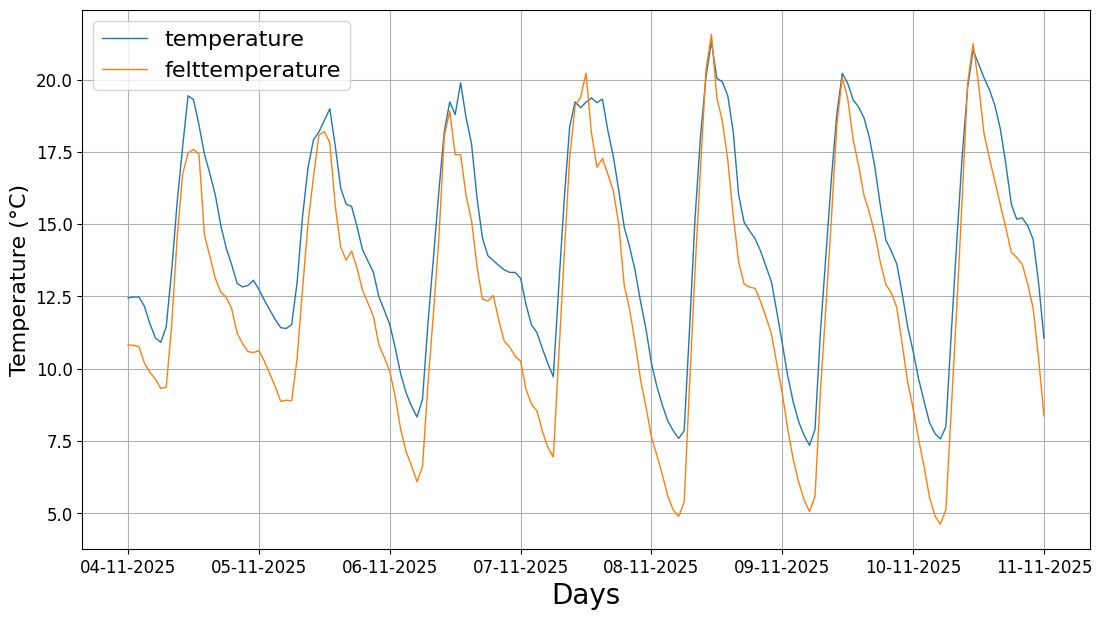

In [ ]:
# temperature / felt temperature

df_to_plot = df # original DataFrame
date_fmt = '%d-%m-%Y' # set an X-axis format to show days (`'%d-%m-%Y'`)
    
plot = plot_data(df_to_plot, 
          x_col='time', y_cols=['temperature', 'felttemperature'], 
          x_label='Days', y_label='Temperature (°C)', 
          graph_type="line", date_format=date_fmt) 
  

### 5.2. 7-Day Overview: Precipitation

Displaying total (rains, showers, snow, hails) and convective precipitation (rains, showers) using bar charts to show daily event-based data.

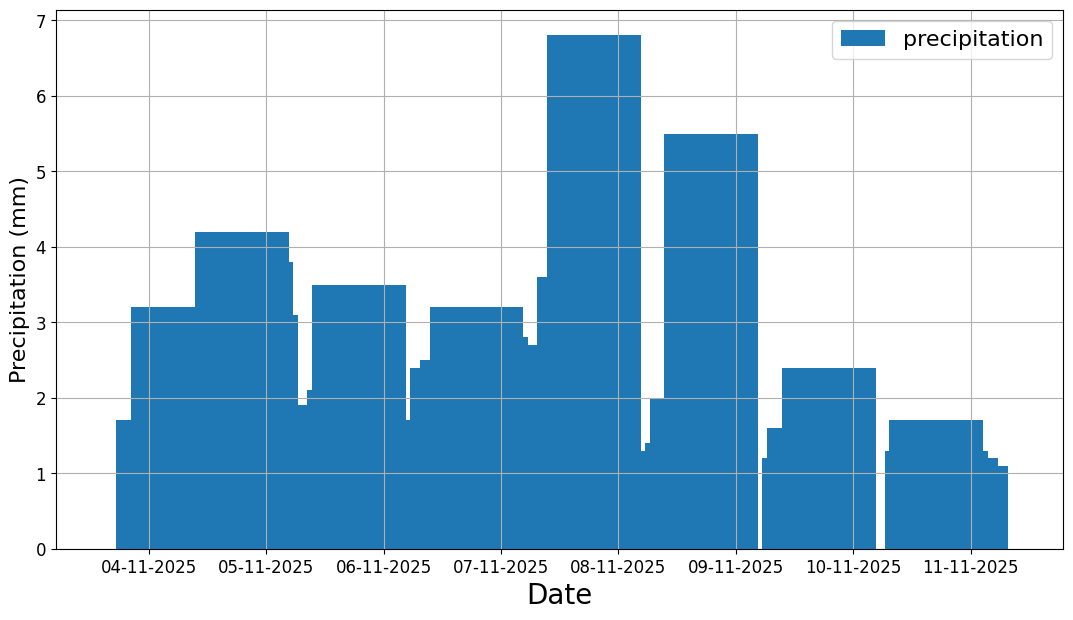

In [ ]:
# all precipitations

df_to_plot = df # original DataFrame
date_fmt = '%d-%m-%Y' # set an X-axis format to show days (`'%d-%m-%Y'`)

plot = plot_data(df_to_plot, 
          x_col='time', y_cols=['precipitation'], 
          x_label='Date', y_label='Precipitation (mm)', 
          graph_type="bar", date_format=date_fmt)


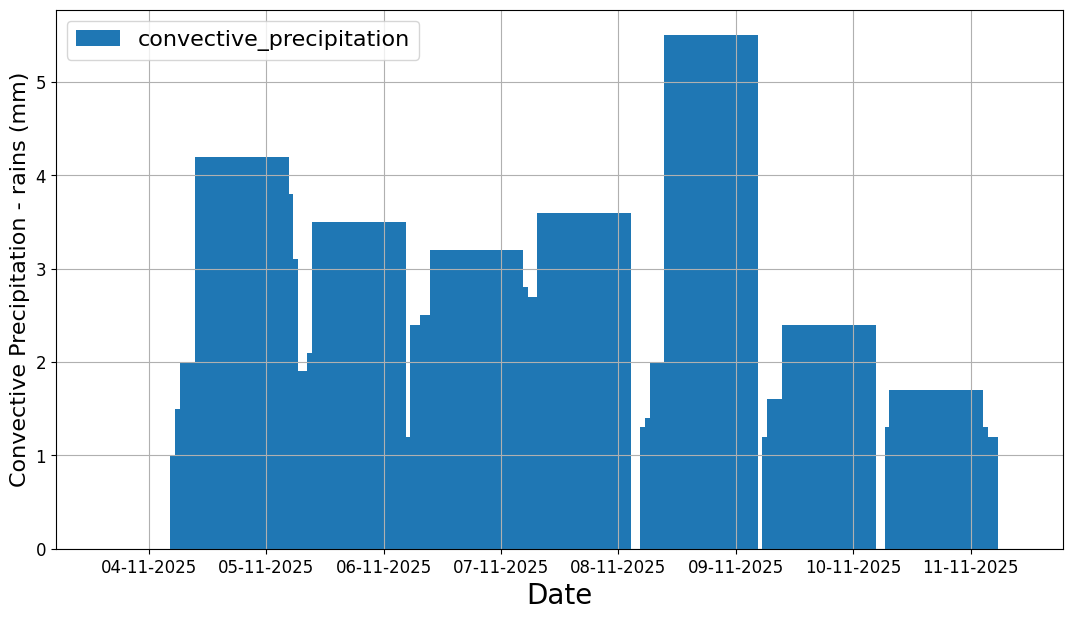

In [23]:
# convective precipitations - rains / showers

df_to_plot = df # original DataFrame
date_fmt = '%d-%m-%Y' # set an X-axis format to show days (`'%d-%m-%Y'`)

plot = plot_data(df_to_plot, x_col='time', y_cols=['convective_precipitation'], 
          x_label='Date', y_label='Convective Precipitation - rains (mm)', 
          graph_type="bar", date_format=date_fmt)

## Phase 6: Detailed View Prototyping (Filtering)

Now we will test the logic for the interactive "daily detail" view. This involves filtering the main DataFrame and creating new plots for the 24-hour period.

### 6.1. Filter Data for 1-Day View

Create a new DataFrame "slice" by filtering the main `df` for a single, hardcoded day. This simulates the user selecting a day in the Streamlit app.

In [17]:
# new dataframe for a chosen day (e.g. 05-11-2025) - we expect 24 entries (hours)

day = "2025-11-05" # simulates user's input
target_day = pd.to_datetime(day).date() # convert "str" input to datetime objet
df_to_plot = df[df['time'].dt.date == target_day] # DataFrame "slice"
print(df_to_plot.info())


<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 24 to 47
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   time                      24 non-null     datetime64[ns]
 1   temperature               24 non-null     float64       
 2   felttemperature           24 non-null     float64       
 3   precipitation             24 non-null     float64       
 4   convective_precipitation  24 non-null     float64       
 5   smooth_temperature        24 non-null     float64       
 6   smooth_felttemperature    24 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.5 KB
None


### 6.2. Detail Viz: 1-Day Temperature

Plot the hourly temperature trend for the selected day.

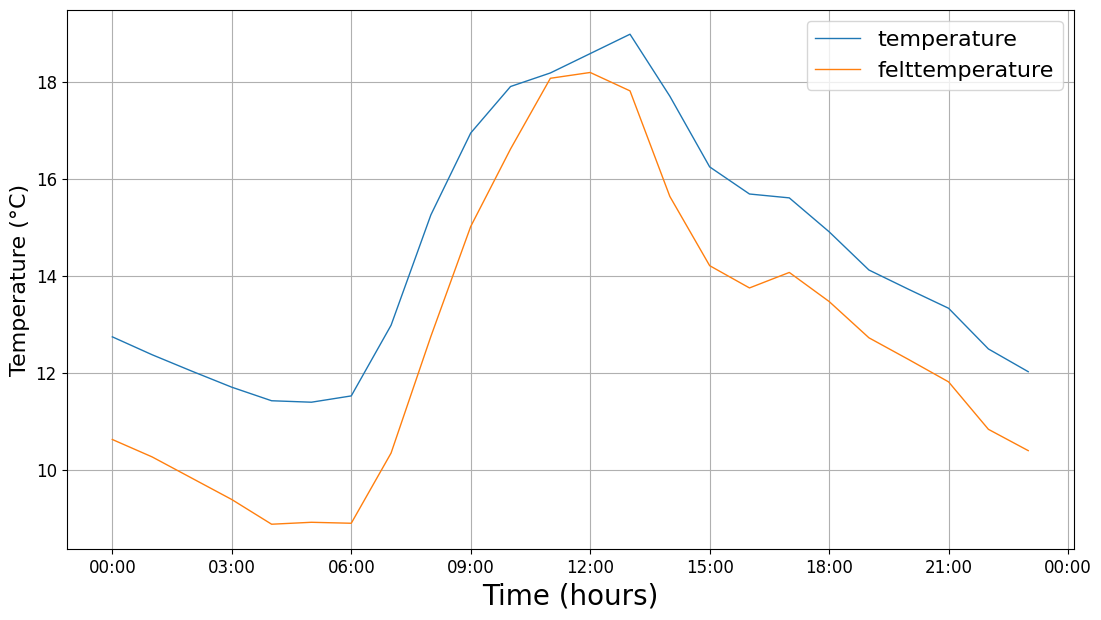

In [24]:
# daily temperatures

day = "2025-11-05" # simulates user's input
target_day = pd.to_datetime(day).date() # convert "str" input to datetime objet
df_to_plot = df[df['time'].dt.date == target_day] # DataFrame "slice"
date_fmt = '%H:%M' # set a new X-axis format to show hours and minutes

plot = plot_data(df_to_plot, 
          x_col='time', y_cols=['temperature', 'felttemperature'], 
          x_label='Time (hours)', y_label='Temperature (°C)', 
          graph_type="line", date_format=date_fmt)


### 6.3. Detail Viz: 1-Day Precipitation

Plot the hourly precipitation data for the selected day. Displaying total (rains, showers, snow, hails) and convective precipitation (rains, showers).

#### 6.3.1. Total precipitation - 1 day

Rains, showers, snow, hails.

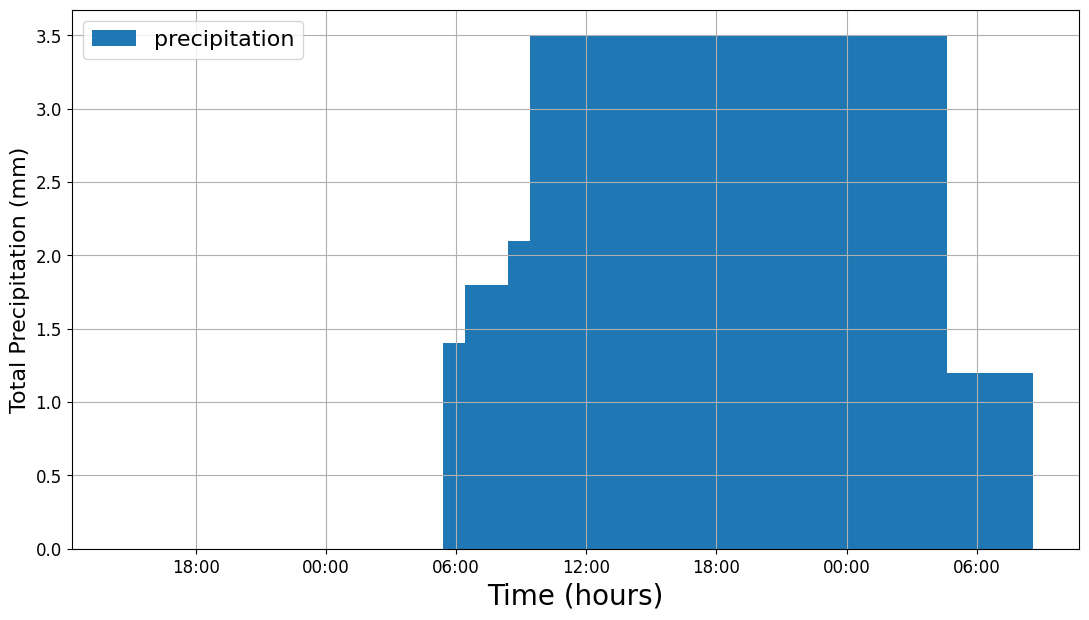

In [25]:
# all daily precipitations

day="2025-11-05"
target_day = pd.to_datetime(day).date() # convert "str" input to datetime objet
df_to_plot = df[df['time'].dt.date == target_day] # DataFrame "slice"
date_fmt = '%H:%M' # set a new X-axis format to show hours and minutes

plot = plot_data(df_to_plot, 
          x_col='time', y_cols=['precipitation'], 
          x_label='Time (hours)', y_label='Total Precipitation (mm)', 
          graph_type="bar", date_format=date_fmt)


#### 6.3.2. Convective precipitation - 1 day

Rains & showers.

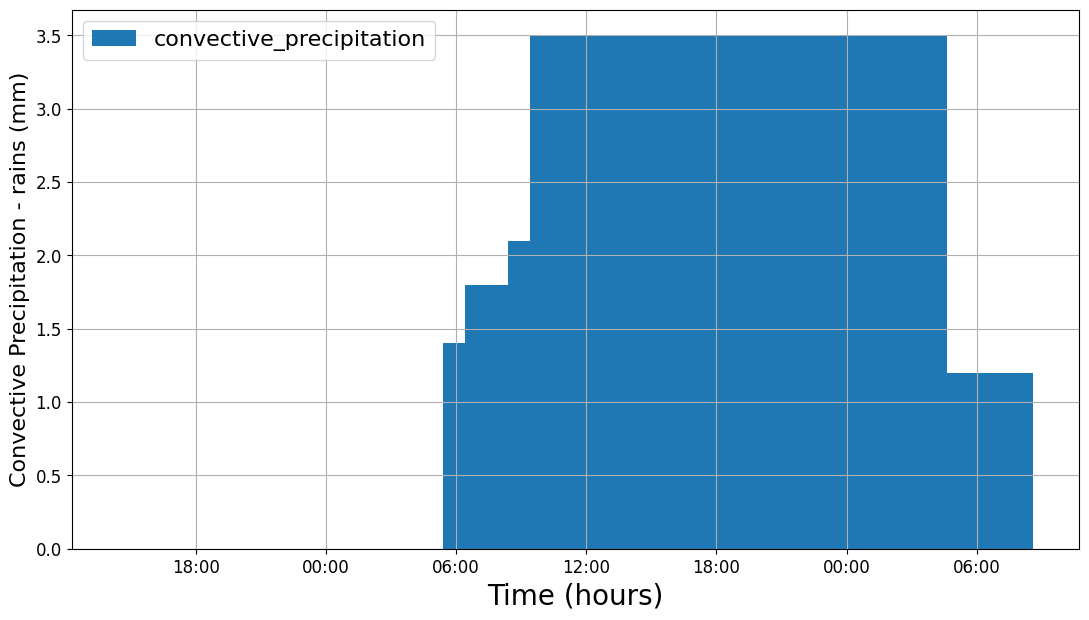

In [26]:
# daily precipitation rains / showers

day="2025-11-05"
target_day = pd.to_datetime(day).date() # convert "str" input to datetime objet
df_to_plot = df[df['time'].dt.date == target_day] # DataFrame "slice"
date_fmt = '%H:%M' # set a new X-axis format to show hours and minutes

plot = plot_data(df_to_plot, 
          x_col='time', y_cols=['convective_precipitation'], 
          x_label='Time (hours)', y_label='Convective Precipitation - rains (mm)', 
          graph_type="bar", date_format=date_fmt)

## Phase 7: Conclusion & Next Steps

This notebook has successfully served its purpose as a data exploration and prototyping "lab".

We have achieved the following:
1.  Loaded and parsed the complex JSON response from the Meteoblue API.
2.  Transformed the raw, parallel lists into a clean, usable Pandas DataFrame.
3.  Prepared the data for visualization by converting data types (`datetime`) and creating derived data (`rolling()`).
4.  Successfully prototyped all required visualizations for both the 7-day overview and the 1-day detailed view.

The data pipeline logic is now validated. The next step is to transfer this logic into a separate Python script (`utils.py`) and build the final interactive Streamlit application (`app.py`) that will import and use this pipeline.